# Cardinality Estimation Experiments

### Experiment Overview

* **Experiment A: Real Data Baselines.** Compare HLL and REC against the "True" cardinality for provided books.

* **Experiment B: Memory vs. Accuracy.** Study how memory usage ($m$ for HLL, $k$ for REC) impacts estimation quality on *Dracula*.

* **Experiment C: Synthetic Scalability.** Validate performance with total control over stream length ($N$) and distinct elements ($n$).

* **Experiment D: The "Alpha" Hypothesis.** Confirm that the skew of the data (Zipf parameter $\alpha$) does not affect accuracy.

* **Experiment E: Hash vs. No-Hash.** Check if Recordinality works well without hashing.

# Setup

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from src.generator import generate_zipf_stream
from src.utils import process_file
from src.runner import compare_algos


plt.style.use('ggplot')

## Exp. A: Real Data Baselines

In [2]:
file = "data/dracula.txt"
file_name = os.path.basename(file)

try:
    stream = process_file(file)
    print(f"Loaded {file_name}: {len(stream)} words")
except FileNotFoundError:
    print(f"Error: {file} not found.")
    stream = []

if stream:
    configs_A = [
        ('HLL', 10),   # Standard HLL
        ('REC', 64),   # Standard REC
        ('PCSA', 10)   
    ]

    df_A = compare_algos(stream, configs_A, file_name, trials=5)

    print("\nExperiment A Results (Averages)")
    summary_A = df_A.groupby("Algorithm")[["Estimate", "True_Count", "Rel_Error"]].mean()
    # display(df_A)
    display(summary_A)

Loaded dracula.txt: 124249 words

Experiment A Results (Averages)


,Estimate,True_Count,Rel_Error
Algorithm,,,
HLL (b=10),9361.683195,9425.0,0.016064
PCSA (b=10),9437.975246,9425.0,0.016719
"REC (k=64, Hash)",8805.119497,9425.0,0.123613


## Exp. B: Memory vs. Accuracy (The "Dracula" Test)

<>:23: SyntaxWarning: invalid escape sequence '\s'
<>:23: SyntaxWarning: invalid escape sequence '\s'
/var/folders/tj/232cdtts49j7tl4hffrc9_vw0000gn/T/ipykernel_22718/78482625.py:23: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(m_vals, theory_err, 'k--', alpha=0.5, label='Theory HLL ($1.04/\sqrt{m}$)')


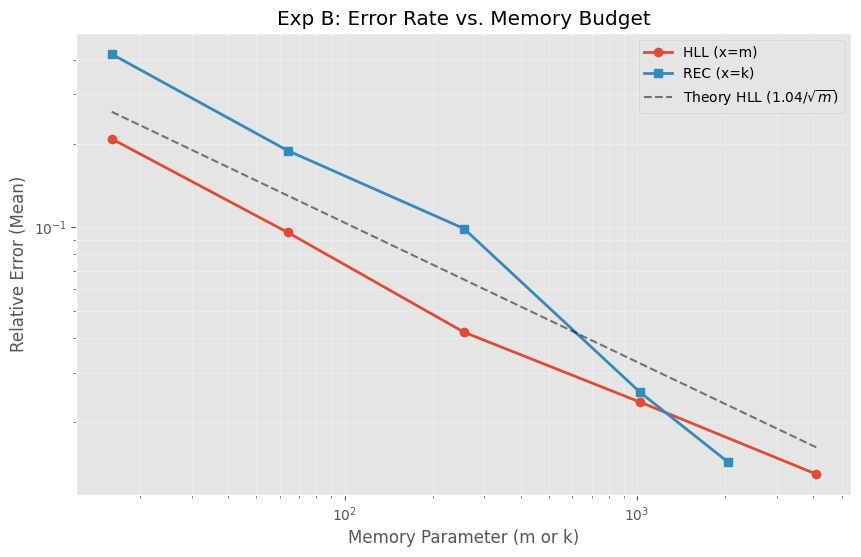

In [3]:
configs_B = []
# HLL: b from 4 to 12 (m = 16 to 4096)
configs_B += [('HLL', b) for b in [4, 6, 8, 10, 12]]
# REC: k from 16 to 2048
configs_B += [('REC', k) for k in [16, 64, 256, 1024, 2048]]

df_B = compare_algos(stream, configs_B, "Dracula", trials=50)


plt.figure(figsize=(10, 6))

# Plot HLL
hll_data = df_B[df_B['Type'] == 'HLL'].groupby('Memory_Scale')['Rel_Error'].mean()
plt.plot(hll_data.index, hll_data.values, marker='o', label='HLL (x=m)', linewidth=2)

# Plot REC
rec_data = df_B[df_B['Type'] == 'REC'].groupby('Memory_Scale')['Rel_Error'].mean()
plt.plot(rec_data.index, rec_data.values, marker='s', label='REC (x=k)', linewidth=2)

# Add theoretical slope line for HLL (1.04 / sqrt(m))
m_vals = np.array(sorted(hll_data.index))
theory_err = 1.04 / np.sqrt(m_vals)
plt.plot(m_vals, theory_err, 'k--', alpha=0.5, label='Theory HLL ($1.04/\sqrt{m}$)')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Memory Parameter (m or k)")
plt.ylabel("Relative Error (Mean)")
plt.title("Exp B: Error Rate vs. Memory Budget")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.show()

## Exp. C: Synthetic Scalability

In [4]:
# synthetic data
syn_stream = generate_zipf_stream(n=5000, alpha=1.0, N=50000)

configs_C = [('HLL', 10), ('REC', 64)]
df_C = compare_algos(syn_stream, configs_C, "Synthetic", trials=5)

print("\nExperiment C Results (N=50k, n=5k)")
display(df_C.groupby("Algorithm")[["Estimate", "Rel_Error"]].mean())


Experiment C Results (N=50k, n=5k)


,Estimate,Rel_Error
Algorithm,,
HLL (b=10),4373.538024,0.022913
"REC (k=64, Hash)",4037.309537,0.095527


## Exp. D: The "Alpha" Hypothesis

Running Alpha variations...


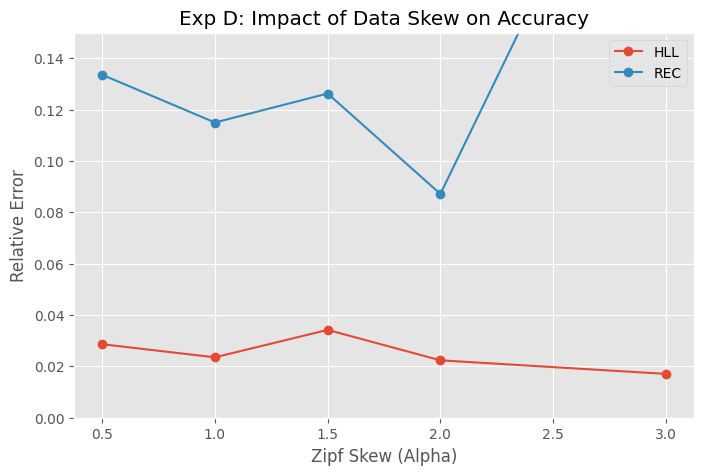

In [5]:
alphas = [0.5, 1.0, 1.5, 2.0, 3.0]
results_D = []
configs_D = [('HLL', 10), ('REC', 64)]

print("Running Alpha variations...")
for a in alphas:
    s = generate_zipf_stream(n=2000, alpha=a, N=20000)
    df = compare_algos(s, configs_D, f"Alpha={a}", trials=5)
    df['Alpha'] = a
    results_D.append(df)

df_D = pd.concat(results_D)

# Plot
plt.figure(figsize=(8, 5))
for algo_type in ['HLL', 'REC']:
    subset = df_D[df_D['Type'] == algo_type]
    means = subset.groupby('Alpha')['Rel_Error'].mean()
    plt.plot(means.index, means.values, marker='o', label=algo_type)

plt.xlabel("Zipf Skew (Alpha)")
plt.ylabel("Relative Error")
plt.ylim(0, 0.15) 
plt.title("Exp D: Impact of Data Skew on Accuracy")
plt.legend()
plt.show()

## Exp. E: Hash vs. No-Hash (REC only)

In [6]:
# generate random integer stream
import numpy as np
rand_ints = np.random.permutation(10000)[:5000]
stream_ints = [str(x) for x in rand_ints]

# compare standard vs no-hash
configs_E = [
    ('REC', 64),          # Uses mmh3 hash
    ('REC_NoHash', 64)    # Uses raw int value
]

df_E = compare_algos(stream_ints, configs_E, "RandomIntegers", trials=10)

print("\nExperiment E: Hash vs No-Hash")
display(df_E.groupby("Algorithm")[["Estimate", "Rel_Error", "Duration"]].mean())


Experiment E: Hash vs No-Hash


,Estimate,Rel_Error,Duration
Algorithm,,,
"REC (k=64, Hash)",5210.240011,0.142171,0.001018
"REC (k=64, NoHash)",6911.920095,0.382384,0.000674
